In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, average_precision_score, precision_recall_curve, make_scorer
import seaborn as sns
import requests
import os
!pip install python-igraph
import networkx as nx
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import sys
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils import compute_sample_weight
import optuna
from sklearn import preprocessing
import networkx as nx


data = pd.read_csv("SAML-D_sampled_data.csv") 

data.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
2999995,23:01:55,2023-06-03,6465028610,2172225510,155695.31,UK pounds,Dirham,UK,UAE,Cross-border,1,Single_large
2999996,08:14:29,2023-05-10,9634559331,8020264563,2481.04,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
2999997,22:05:45,2022-12-15,1240988490,4597902876,3119.80,UK pounds,Yen,UK,UK,Cheque,1,Structuring
2999998,22:17:46,2022-10-18,6770601554,6128626942,76.65,UK pounds,Naira,UK,Nigeria,Cash Withdrawal,1,Cash_Withdrawal
2999999,05:46:53,2023-04-05,8424086459,3934928194,4284.21,UK pounds,Albanian lek,UK,Albania,Cross-border,1,Deposit-Send


In [4]:


data['Hour'] = pd.to_datetime(data['Time']).dt.hour

data['Date_Year'] = pd.to_datetime(data['Date']).dt.year
data['Date_Month'] = pd.to_datetime(data['Date']).dt.month
data['Date_Day'] = pd.to_datetime(data['Date']).dt.day

data.drop(columns=['Laundering_type'], inplace=True)
data.drop(columns=['Time', 'Date'], inplace=True)




data.head()


,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Hour,Date_Year,Date_Month,Date_Day
0,5962016906,3377238139,5285.95,UK pounds,UK pounds,UK,UK,ACH,0,2,2023,6,2
1,985504393,8645656726,6703.57,UK pounds,UK pounds,UK,UK,ACH,0,17,2022,10,15
2,2012195326,8080878478,2999.20,UK pounds,UK pounds,UK,UK,Cash Deposit,0,9,2022,10,24
3,9696055743,1969723275,5844.41,UK pounds,UK pounds,UK,UK,Credit card,0,21,2022,12,16
4,9248338532,3039356124,9107.88,UK pounds,UK pounds,UK,UK,Credit card,0,16,2023,1,22


In [5]:


for col in ['Sender_account', 'Receiver_account']:
    data[col] = data[col].astype(str)
data.dropna(subset=["Sender_account", "Receiver_account"], inplace=True)

# Networkfeatures
G = nx.DiGraph()
edges = list(zip(data["Sender_account"], data["Receiver_account"], data["Amount"]))
G.add_weighted_edges_from(edges)

G_ig = ig.Graph.TupleList(edges, directed=True)
data["degree_centrality"] = data["Sender_account"].map(dict(zip(G_ig.vs["name"], G_ig.degree()))).fillna(0)
pagerank_scores = G_ig.pagerank()
data["pagerank"] = data["Sender_account"].map(dict(zip(G_ig.vs["name"], pagerank_scores))).fillna(0)

# Timebased features
data["rolling_24h_amount"] = data.groupby("Sender_account")["Amount"]\
                                 .rolling(50).sum().reset_index(0, drop=True).fillna(0)
data["transaction_count"] = data.groupby("Sender_account")["Amount"].transform("count")

# Feature selection
features = data.drop(columns=[
    'Is_laundering',
    'rolling_24h_amount',
    'Sender_bank_location',
    'Payment_currency',
    'Received_currency'
]).copy()

# Add features manually
features["degree_centrality"] = data["degree_centrality"]
features["pagerank"] = data["pagerank"]
features["rolling_24h_amount"] = data["rolling_24h_amount"]
features["transaction_count"] = data["transaction_count"]
features.drop(columns=['Date_Year', 'Date_Month'], inplace=True, errors='ignore')

# Target
target = data['Is_laundering']



In [6]:
# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features, target, test_size=0.3, stratify=target, random_state=42
)

#  Train/validation split within train
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# categorical encoding
categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_type', 'Date_Day']
encoders = {}
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    # "Combine columns from train, validation, and test sets to see all unique values.
    combined = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    
    # Fit on combined
    le.fit(combined)
    
    # transform seperate
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    encoders[col] = le  


# numerical features scaling
numerical_cols = ['Hour', 'Amount']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


<ipython-input-6-630261d891e1>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.transform(X_train[col].astype(str))
<ipython-input-6-630261d891e1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = le.transform(X_val[col].astype(str))
<ipython-input-6-630261d891e1>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Train shape: (1680000, 11)
Validation shape: (420000, 11)
Test shape: (900000, 11)


In [35]:
!pip install optuna

In [7]:


le = LabelEncoder()
combined = pd.concat([X_train["Receiver_bank_location"], X_val["Receiver_bank_location"], X_test["Receiver_bank_location"]]).astype(str)
le.fit(combined)

X_train["Receiver_bank_location"] = le.transform(X_train["Receiver_bank_location"].astype(str))
X_val["Receiver_bank_location"] = le.transform(X_val["Receiver_bank_location"].astype(str))
X_test["Receiver_bank_location"] = le.transform(X_test["Receiver_bank_location"].astype(str))






<ipython-input-7-d4bef4a73bfb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Receiver_bank_location"] = le.transform(X_train["Receiver_bank_location"].astype(str))
<ipython-input-7-d4bef4a73bfb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val["Receiver_bank_location"] = le.transform(X_val["Receiver_bank_location"].astype(str))
<ipython-input-7-d4bef4a73bfb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [8]:
print(X_test)

         Sender_account  Receiver_account    Amount  Receiver_bank_location  \
1002978          116314            160958 -0.254320                      16   
2020803          248365             22234 -0.327182                      16   
42581            249397            288807 -0.272588                      16   
1739854          159199            204510  0.066471                      16   
396445           241747            523346  0.684571                      16   
...                 ...               ...       ...                     ...   
1672801          254985            545425 -0.063109                      16   
2798920          190240            334258  0.579857                      16   
388010           114926            160276 -0.123645                      16   
2315930           63818            518057 -0.344419                      16   
2988217          103914            283630 -0.150035                      16   

         Payment_type      Hour  Date_Day  degree_c

In [23]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
    
    np.random.seed(random_state)

    
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen


alpha = 0.001 


y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train_true, label_ratio=0.5)



# sample weights
sample_weights = compute_sample_weight(class_weight={0: 1, 1: 10}, y=y_train_pu)


In [42]:

#def objective(trial):
 #   params = {
  #      "objective": "binary:logistic",
   #     "eval_metric": "logloss",
    #    "use_label_encoder": False,
     #   "tree_method": "hist",
      #  "n_estimators": trial.suggest_int("n_estimators", 50, 600),
       # "max_depth": trial.suggest_int("max_depth", 3, 30),
        #"learning_rate": trial.suggest_float("learning_rate", 0.0004, 0.3, log=True),
#        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
 #       "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
  #      "gamma": trial.suggest_float("gamma", 0.0, 5.0),
   #     "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
    #    "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
     #   "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 20.0)
#    }
    
#    model = XGBClassifier(**params)
 #   skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  #  model.fit(X_train, y_train_true)
   # y_val_pred = model.predict(X_val)
    #score = f1_score(y_val_true, y_val_pred)
#    return score


#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=30, timeout=1200)

#print("Beste hyperparameters:", study.best_params)

# Gebruik beste model
#best_params = study.best_params
#best_params.update({
 #   "objective": "binary:logistic",
  #  "eval_metric": "logloss",
   # "use_label_encoder": False,
    #"tree_method": "hist"
#})
#xgb_best = XGBClassifier(**best_params)



[I 2025-05-10 19:46:04,018] A new study created in memory with name: no-name-73261ed0-f4fc-449f-be18-40d05056ddaf
[W 2025-05-10 19:46:09,364] Trial 0 failed with parameters: {'n_estimators': 443, 'max_depth': 3, 'learning_rate': 0.163648701492311, 'subsample': 0.8969054569017576, 'colsample_bytree': 0.8045847213950985, 'gamma': 3.0363295419595064, 'reg_alpha': 2.7827872609785063, 'reg_lambda': 6.2442409207334615, 'scale_pos_weight': 17.249764843970585} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-42-48a02af40283>", line 20, in objective
    model.fit(X_train, y_train_true)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 1519, in fit
    self._B

KeyboardInterrupt: 

In [24]:
#Beste hyperparameters: {'n_estimators': 319, 'max_depth': 8, 'learning_rate': 0.1688920984603451, 
#'subsample': 0.9850456682674417, 'colsample_bytree': 0.8660565630315229, 'gamma': 0.12027963453338364, 
#'reg_alpha': 3.1831310264770565,
#'reg_lambda': 2.6879283883951866, 'scale_pos_weight': 10.21510245381897}


# Beste hyperparameters  via Optuna
xgb_best = XGBClassifier(
    n_estimators=319,
    max_depth=8,
    learning_rate=0.1688920984603451,
    subsample=0.9850456682674417,
    colsample_bytree=0.8660565630315229,
    gamma=0.12027963453338364,
   reg_alpha=3.1831310264770565,
    reg_lambda=2.6879283883951866,
   scale_pos_weight=10.21510245381897,
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    tree_method="hist",
    random_state=42
)


Beste threshold (voor F1): 0.2005
Model evaluatie (gewogen + getuned + threshold-optimalisatie):
Accuracy: 0.9990
Precision: 0.5595
Recall: 0.3070
F1-score: 0.3964
ROC AUC: 0.9841
PR AUC: 0.3718


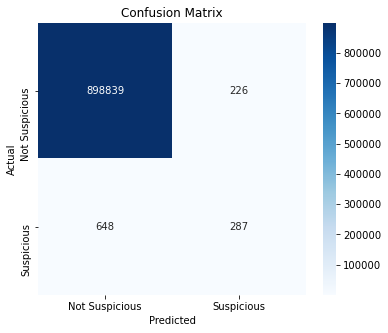

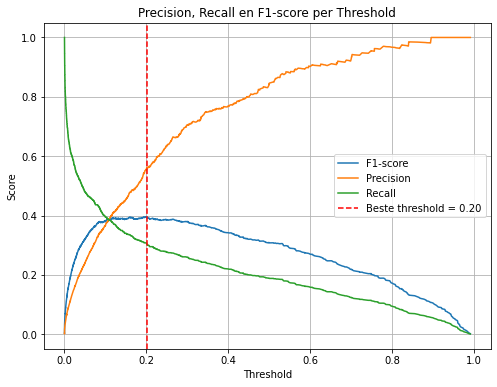

In [25]:

xgb_best.fit(X_train, y_train_pu)


y_proba = xgb_best.predict_proba(X_test)[:, 1]

# threshold tuning based on F1
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Beste threshold (voor F1): {best_thresh:.4f}")

# predictions
y_pred = (y_proba >= best_thresh).astype(int)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("Model evaluatie (gewogen + getuned + threshold-optimalisatie):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Suspicious', 'Suspicious'],
    yticklabels=['Not Suspicious', 'Suspicious']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Threshold perfomance
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.plot(thresholds, prec[:-1], label="Precision")
plt.plot(thresholds, rec[:-1], label="Recall")
plt.axvline(x=best_thresh, color='r', linestyle='--', label=f'Beste threshold = {best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall en F1-score per Threshold")
plt.legend()
plt.grid()
plt.show()


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_proba)
auc_pu = roc_auc_score(y_test, y_proba)

np.savez("roc_XGB.npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_proba)

In [13]:
np.save("preds_XGB.npy", y_pred)